In [2]:
import pandas as pd
from lyricsgenius import Genius
import time

# 1. Cargar tu data (asumiendo que ya la tienes en un DataFrame)
df = pd.read_csv('/home/cesar/music-recommendation-multimodal/data/spotify-kaggle/interim/songs_catalog.csv') 
# Para el ejemplo, usaré las columnas que veo en tu imagen: 'artist_name', 'track_name', 'track_id'

# 2. Configurar Genius
GENIUS_TOKEN = "1Q_QAYNM-YTeSQFnhTE3BFqgCFfi6-TYZAjwC4IZxNUREJ_vlAItMV5DFpKoupsU"
genius = Genius(GENIUS_TOKEN)

# Configuraciones para evitar falsos positivos y timeouts
genius.verbose = False # Para que no imprima tanto en consola
genius.remove_section_headers = False # Mantenlo en False por ahora (te explico abajo por qué)
genius.skip_non_songs = True
genius.excluded_terms = ["(Remix)", "(Live)"] # Opcional

def get_lyrics_safe(title, artist):
    """
    Intenta obtener la letra manejando errores de conexión y nombres complejos.
    """
    try:
        # Intento 1: Búsqueda directa
        song = genius.search_song(title, artist)
        
        # Intento 2: Si falla, limpieza básica (ej. quitar cosas entre paréntesis del artista)
        if not song and "(" in artist:
            clean_artist = artist.split('(')[0].strip() # Simplificación burda
            song = genius.search_song(title, clean_artist)
            
        if song:
            return song.lyrics
        else:
            return None
    except Exception as e:
        print(f"Error en {title}: {e}")
        return None

# 3. Iteración (¡Con guardado progresivo!)
# Dado que son 10k, no querrás correr todo y que falle en la 9999.
lyrics_data = []

print("Iniciando descarga...")
for index, row in df.iterrows():
    track = row['track_name']
    artist = row['artist_name']
    track_id = row['track_id']
    
    lyrics = get_lyrics_safe(track, artist)
    
    lyrics_data.append({
        'track_id': track_id, # Usamos tu ID para cruzar después
        'lyrics': lyrics,
        'status': 'found' if lyrics else 'not_found'
    })
    
    # Delay respetuoso para no saturar la API (opcional pero recomendado)
    if index % 10 == 0:
        print(f"Procesando índice {index}...")
        time.sleep(1)

# 4. Convertir a DataFrame y Guardar
df_lyrics = pd.DataFrame(lyrics_data)
df_lyrics.to_csv('lyrics_dataset_10k.csv', index=False)
print("¡Terminado!")

Iniciando descarga...
Procesando índice 0...
Procesando índice 10...
Procesando índice 20...
Procesando índice 30...
Procesando índice 40...
Error en Dear Mama: Unexpected response status code: 500. Expected 200 or 204. Response body: <!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Worker threw exception | api.genius.com | Cloudflare</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/cf.errors.css" />
<!--[if lt IE 9]><lin

In [3]:
# vamos a revisar cuantas letras se encontraron y cuantas no
print(df_lyrics['status'].value_counts())   

status
found        8544
not_found    2137
Name: count, dtype: int64


Vamos a intentar descubrir qué pasa con las canciones que no lograron obtener letra, quizás podemos entender mejor la distribución del error. 

Cargando archivos...

=== RESUMEN GLOBAL ===
Total canciones: 12263
Encontradas:     9511 (77.56%)
No encontradas:  2752 (22.44%)

=== TOP 20 ARTISTAS CON MÁS FALLOS ===
artist_name
Hans Zimmer            26
Carlos Gardel          23
The Prodigy            22
Autechre               21
Boøwy                  19
Freestylers            19
Yanni                  19
Casino Versus Japan    17
Susumu Yokota          17
Plastikman             17
Carl Craig             16
Håkan Hellström        16
Orbital                15
Plaid                  14
Pig Destroyer          14
Joe Satriani           13
Moodymann              13
Djavan                 12
Drexciya               12
Two Lone Swordsmen     12
Name: count, dtype: int64


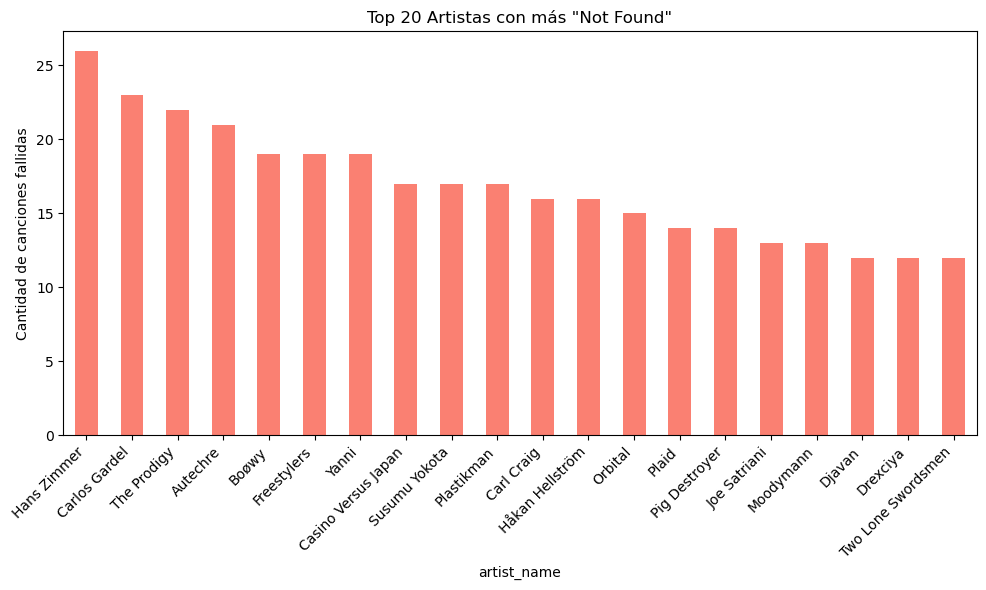


=== ANÁLISIS DE POSIBLES INSTRUMENTALES (En fallidas) ===
Busqueda de palabras clave en el título:
 - Contiene 'Symphony': 1 canciones
 - Contiene 'Sonata': 1 canciones
 - Contiene 'Orchestra': 5 canciones
 - Contiene 'Theme': 16 canciones
 - Contiene 'No.': 142 canciones
 - Contiene 'Op.': 65 canciones

Estimación total de instrumentales/clásica en fallos: ~230


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. CARGA DE DATOS ---
print("Cargando archivos...")
# Tu catálogo original (donde están los nombres correctos de artistas y canciones)
df_catalog = pd.read_csv('/home/cesar/music-recommendation-multimodal/data/spotify-kaggle/interim/songs_catalog.csv')

# El archivo que generó el script de descarga
df_lyrics = pd.read_csv('/home/cesar/music-recommendation-multimodal/notebooks/lyrics_dataset_10k.csv')

# --- 2. UNIFICACIÓN (MERGE) ---
# Unimos por 'track_id' para tener en una sola tabla la info del artista y si se encontró la letra
# Usamos 'left' para mantener todas las canciones del catálogo original
df_full = df_catalog.merge(df_lyrics[['track_id', 'lyrics']], on='track_id', how='left')

# --- 3. DEFINICIÓN DE STATUS ---
# Si la columna 'lyrics' está vacía o es NaN, lo marcamos como 'not_found'
def check_status(text):
    if pd.isna(text) or str(text).strip() == "":
        return 'not_found'
    return 'found'

df_full['status'] = df_full['lyrics'].apply(check_status)

# --- 4. ESTADÍSTICAS GENERALES ---
total = len(df_full)
found = len(df_full[df_full['status'] == 'found'])
not_found = len(df_full[df_full['status'] == 'not_found'])

print(f"\n=== RESUMEN GLOBAL ===")
print(f"Total canciones: {total}")
print(f"Encontradas:     {found} ({found/total:.2%})")
print(f"No encontradas:  {not_found} ({not_found/total:.2%})")

# --- 5. ANÁLISIS DE FALLOS POR ARTISTA ---
# Filtramos solo las que fallaron
df_failed = df_full[df_full['status'] == 'not_found']

print(f"\n=== TOP 20 ARTISTAS CON MÁS FALLOS ===")
# Contamos cuántas veces aparece cada artista en la lista de fallos
top_failed = df_failed['artist_name'].value_counts().head(20)
print(top_failed)

# (Opcional) Gráfico simple
plt.figure(figsize=(10, 6))
top_failed.plot(kind='bar', color='salmon')
plt.title('Top 20 Artistas con más "Not Found"')
plt.ylabel('Cantidad de canciones fallidas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 6. DETECCIÓN DE POSIBLES INSTRUMENTALES ---
# Buscamos palabras clave en el TITULO de las canciones fallidas
keywords = ['Instrumental', 'Symphony', 'Concerto', 'Sonata', 'Orchestra', 'Theme', 'Score', 'No.', 'Op.', 'Soundtrack']

print(f"\n=== ANÁLISIS DE POSIBLES INSTRUMENTALES (En fallidas) ===")
print("Busqueda de palabras clave en el título:")

possible_instrumentals = 0
for word in keywords:
    # Contamos cuántos títulos contienen la palabra (ignorando mayúsculas/minúsculas)
    count = df_failed[df_failed['track_name'].str.contains(word, case=False, na=False)].shape[0]
    if count > 0:
        print(f" - Contiene '{word}': {count} canciones")
        possible_instrumentals += count

print(f"\nEstimación total de instrumentales/clásica en fallos: ~{possible_instrumentals}")

# Falsos Negativos
A primera vista, parece que nuestra lista de fallos al encontrar letra tiene más que ver con la naturaleza de la canción como tal, que con algún fallo en la búsqueda o descarga. Es decir, no encontramos con que en el TOP 20 artistas con menos letras encontradas están nombres como:

* Hans Zimmer (Soundtracks Épicos)
* Yanni (Instrumental)
* Joe Satriani (Guitarrista Instrumental)

Así como otros artistas que, tras investigarlos, se dedican a la creación de canciones de música electrónica, techno o IDM. Vemos personajes como Auterchre, Plastikman, o Carl Craig. La música de este subconjunto está dominado por sintentizadores y ritmo. Este grupo de canciones representa el 70% de nuestros fallos. 

Hay otra categoría de fallos, como lo es al momento de buscar canciones o artistas de regiones con idiomas más extraños de lo común. Vemos que hay artistas con caracteres especiales como: Boøwy (Banda japonesa, la "ø" puede confundir a la búsqueda), Håkan Hellström (Sueco, la "å" y "ö").

También nos encontramos con canciones mucho menos populares o de géneros underground, como lo son variantes del Metal, pero más pesadas. 

## Acciones a tomar

Considero que no vale tanto la pena hacer una segunda pasada para recuperar canciones de artistas que caen en la categoría de gallos debido a caracteres especiales. El exploratorio nos indica que la mayoría de los errores ocurrieron debido a que la canción no tiene letra.

Sin embargo, podemos tratar esta falta de letra. No es necesario borrar los ítems, más bien podríamos reemplazar el string vacío por un caracter especial que reemplace también a los NaN o `Not_found`, como lo sería `<INSTRUMENTAL>` o `[NO_LYRICS]`. Creo que de esa manera podemos trabajar mejor con un LM como BERT. Lo anterior generaría un embedding específico para canciones instrumentales o sin letras, que semánticamente serviría para distinguir entre canciones. 

## Sigue tratar el corpus para que pueda ser procesado por un Transformer

La propuesta sería eliminar metadatos de estructura, como cosas tipo `[Verse 1]`, `[Chorus]` o `[Instrumental Break]`. También podrías eliminar cosas intrínsecas de Genius como `125Embed` o `You might also like`. Generar estructuras como `[NO_LYRICS]`, que mencionamos anteriormente. 

In [ ]:
'''
import pandas as pd
import re

# 1. Cargar el dataset con las letras crudas
# Asegúrate de usar el archivo merged o el de lyrics
df = pd.read_csv('lyrics_dataset_10k.csv') 

def clean_genius_lyrics(text):
    """
    Limpieza profunda específica para formatos de Genius.com
    """
    # Si no es string (es NaN), retornamos el token especial
    if not isinstance(text, str) or text.strip() == "":
        return "<INSTRUMENTAL>"
    
    # A. Limpieza de Ruido Específico de Genius
    # 1. Eliminar identificadores de estructura [Chorus], [Verse 1], etc.
    text = re.sub(r'\[.*?\]', ' ', text)
    
    # 2. Eliminar basura común al final (ej: "15Embed", "Embed")
    # Genius a veces pone el numero de embeds al final pegado a la ultima palabra
    text = re.sub(r'\d*Embed$', '', text)
    
    # 3. Eliminar texto de "You might also like" que a veces se cuela
    text = re.sub(r'You might also like', '', text)
    
    # B. Limpieza General
    # 4. Eliminar caracteres que no sean palabras o puntuación básica (opcional)
    # Para Deep Learning moderno (BERT), a veces es mejor dejar la puntuación.
    # Si usas TF-IDF, descomenta la siguiente línea:
    # text = re.sub(r'[^\w\s]', '', text) 

    # 5. Normalizar espacios (quitar saltos de línea excesivos y espacios dobles)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 6. Lowercase (Generalmente recomendado, aunque modelos como BERT-cased distinguen mayúsculas)
    text = text.lower()
    
    return text

print("Limpiando letras...")
# Aplicar la función
df['lyrics_clean'] = df['lyrics'].apply(clean_genius_lyrics)

# Verificamos el antes y después de una canción aleatoria
sample = df[df['lyrics_clean'] != "<instrumental>"].sample(1).iloc[0]
print(f"\n--- Original ({sample['track_id']}) ---\n{str(sample['lyrics'])[:200]}...")
print(f"\n--- Limpia ---\n{sample['lyrics_clean'][:200]}...")

# Guardamos el dataset listo para Modelado
df.to_csv('dataset_letras_procesado.csv', index=False)
print("\n¡Limpieza terminada! Archivo guardado: 'dataset_letras_procesado.csv'")
'''

## Embeddings de las letras

Una vez todo ello, vamos a tener que decidir cómo transformar nuestras letras en vectores. Tenemos dos caminos principales:

* Enfoque Clásico | Bag of Words o TF-IDF: rápido e interpretable, podemos ver qué palabras tienen más peso, pero se pierde contexto ("No te quiero" sería lo mismo que "No quiero te")

* Enfoque con DL: podemos utilizar sentence embbedings. De hecho, BERT ya genera los embbedings. 

